<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

<h1><center>Assignment 02</center></h1>
<h2>
Ayushman Anupam (MDS202411)
</h2>

</div>

In [91]:
# importing needed libraries

import csv
import os
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from nltk import bigrams, trigrams

folder_path = "data"
# seed = 2, 9, 13, 42, 123
split_random_seed = 123 # reandom seed used for splitting data

In [92]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Reading the main SMS file**

In [93]:
df_path = os.path.join(folder_path, "SMSSpamCollection")
df = pd.read_csv(df_path, 
                 sep='\t', 
                 quoting=csv.QUOTE_NONE,
                 names = ['label', 'message'])

print("Total number of SMSs:",len(df))
print("\nSample of SMS file \n",df.head(10))

Total number of SMSs: 5574

Sample of SMS file 
   label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...


# **Data Preprocessing**

In [94]:
df['length'] = df['message'].map(lambda text: len(text))
df.head(10)

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147
6,ham,Even my brother is not like to speak with me. ...,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,157
9,spam,Had your mobile 11 months or more? U R entitle...,154


### **Checking if message has URls or number**
Most spam has some of url and number embedded in it, we can see this from our result

In [95]:
df['has_url']   = df['message'].str.contains('http')
df['has_number'] = df['message'].str.contains(r'\d')

df.groupby('label')[['has_url', 'has_number']].mean()

,has_url,has_number
label,,
ham,0.000000,0.156619
spam,0.028112,0.947791


### **Exclamation mark and caps ratio of ham vs spam**

In [96]:
df['exclamation_count'] = df['message'].apply(lambda x: x.count('!'))
df['caps_ratio'] = df['message'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
)

df.groupby('label')[['exclamation_count', 'caps_ratio']].mean()

,exclamation_count,caps_ratio
label,,
ham,0.176507,0.05848
spam,0.729585,0.11091


## **Preprocessing SMS text**

In [97]:
# finding sets of english stopwords
stop_words = set(stopwords.words('english'))

# function for preprocessing SMS
def preprocess_text(text):
    tokens = word_tokenize(text)   # Tokenization
    tokens = [token for token in tokens if token not in stop_words]   # Stopword removal
    
    lemmatizer = WordNetLemmatizer()   # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    tokens = [token.lower() for token in tokens]   # Converting all text to lowercase
    tokens = [token for token in tokens if token != '']   # Removing empty strings
    
    return tokens

df['message'] = df['message'].apply(preprocess_text)
df.head()

,label,message,length,has_url,has_number,exclamation_count,caps_ratio
0,ham,"[go, jurong, point, ,, crazy, .., available, b...",111,False,False,0,0.027027
1,ham,"[ok, lar, ..., joking, wif, u, oni, ...]",29,False,False,0,0.068966
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",155,False,True,0,0.064516
3,ham,"[u, dun, say, early, hor, ..., u, c, already, ...",49,False,False,0,0.040816
4,ham,"[nah, i, n't, think, go, usf, ,, life, around,...",61,False,False,0,0.032787


### **Replace string length with number of different tokens in preprocessed SMS**

In [98]:
df['length'] = df['message'].apply(len)
df.head(10)

,label,message,length,has_url,has_number,exclamation_count,caps_ratio
0,ham,"[go, jurong, point, ,, crazy, .., available, b...",20,False,False,0,0.027027
1,ham,"[ok, lar, ..., joking, wif, u, oni, ...]",8,False,False,0,0.068966
2,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",32,False,True,0,0.064516
3,ham,"[u, dun, say, early, hor, ..., u, c, already, ...",11,False,False,0,0.040816
4,ham,"[nah, i, n't, think, go, usf, ,, life, around,...",10,False,False,0,0.032787
5,spam,"[freemsg, hey, darling, 's, 3, week, 's, word,...",26,False,True,2,0.047619
6,ham,"[even, brother, like, speak, ., they, treat, l...",11,False,False,0,0.025974
7,ham,"[as, per, request, 'melle, melle, (, oru, minn...",22,False,True,0,0.062500
8,spam,"[winner, !, !, as, valued, network, customer, ...",26,False,True,3,0.076433
9,spam,"[had, mobile, 11, month, ?, u, r, entitled, up...",22,False,True,1,0.090909


### **Encoding label ham as '0' and spam as '1'**

In [99]:
# function for encoding ham as 0 and spam as 1
def encode(text):
    if text == 'spam':
        return 1
    elif text == 'ham':
        return 0
df['label'] = df['label'].apply(encode)

### **Splitting into Train set, Test set and Validation set**

In [100]:
def split_data(df, seed=42, train_size=0.7, val_size=0.2, test_size=0.1):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6

    # Train vs (Val + Test)
    train_df, val_test_df = train_test_split(
        df,
        test_size=1 - train_size,
        random_state=seed
    )

    # Val vs Test (stratify again)
    val_df, test_df = train_test_split(
        val_test_df,
        test_size=test_size / (val_size + test_size),
        random_state=seed
    )

    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(df, seed = split_random_seed)

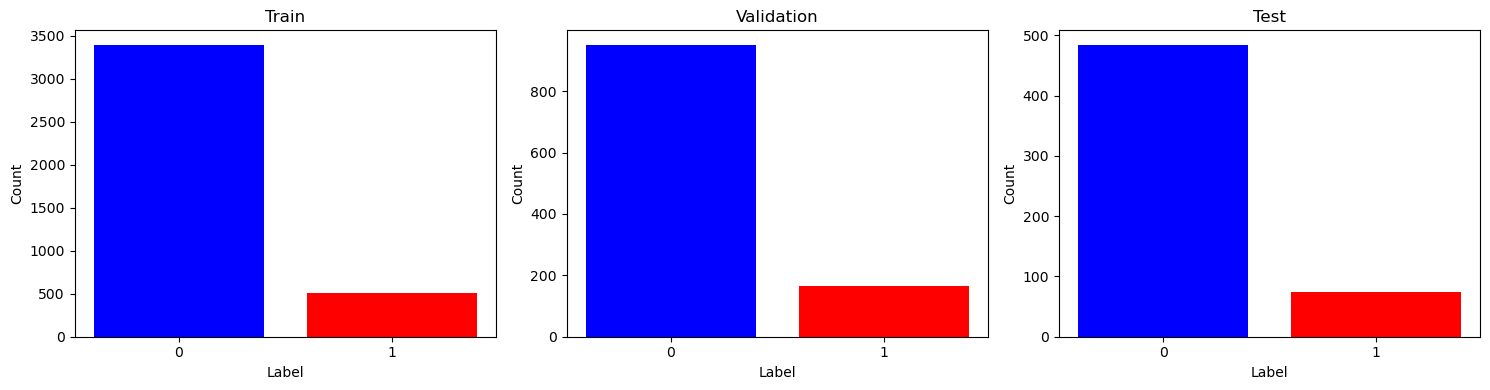

In [101]:
def plot_label_distribution(train_df, val_df, test_df):
    datasets = {
        "Train": train_df,
        "Validation": val_df,
        "Test": test_df
    }

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, (name, data) in zip(axes, datasets.items()):
        counts = data['label'].value_counts().sort_index()

        ax.bar([0], [counts.get(0, 0)], color='blue', label='Ham (0)')
        ax.bar([1], [counts.get(1, 0)], color='red', label='Spam (1)')

        ax.set_xticks([0, 1])
        ax.set_title(name)
        ax.set_xlabel("Label")
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

plot_label_distribution(train_df, val_df, test_df)

In [102]:
def print_counts(train_df, val_df, test_df):
    datasets = {
        "Train": train_df,
        "Validation": val_df,
        "Test": test_df
    }

    for name, data in datasets.items():
        total = len(data)
        ham = (data['label'] == 0).sum()
        spam = (data['label'] == 1).sum()

        print(f"\n{name} Set")
        print(f"Total datapoints: {total}")
        print(f"Ham (0): {ham}")
        print(f"Spam (1): {spam}")

print_counts(train_df, val_df, test_df)



Train Set
Total datapoints: 3901
Ham (0): 3392
Spam (1): 509

Validation Set
Total datapoints: 1115
Ham (0): 951
Spam (1): 164

Test Set
Total datapoints: 558
Ham (0): 484
Spam (1): 74


In [103]:
def print_percentages(train_df, val_df, test_df):
    datasets = {
        "Train": train_df,
        "Validation": val_df,
        "Test": test_df
    }

    for name, data in datasets.items():
        total = len(data)
        ham = (data['label'] == 0).sum()
        spam = (data['label'] == 1).sum()

        ham_pct = 100 * ham / total
        spam_pct = 100 * spam / total

        print(f"\n{name} Set")
        print(f"Ham %: {ham_pct:.2f}%")
        print(f"Spam %: {spam_pct:.2f}%")
        print(f"Check Sum: {ham_pct + spam_pct:.2f}%")

print_percentages(train_df, val_df, test_df)



Train Set
Ham %: 86.95%
Spam %: 13.05%
Check Sum: 100.00%

Validation Set
Ham %: 85.29%
Spam %: 14.71%
Check Sum: 100.00%

Test Set
Ham %: 86.74%
Spam %: 13.26%
Check Sum: 100.00%


In [104]:
# # Checking distribution for different random seed

# for seed in [1, 7, 42, 100]:
#     print(f"\n\n========= Seed = {seed} =========")
#     train_df, val_df, test_df = split_data(df, seed=seed)
#     print_percentages(train_df, val_df, test_df)

In [105]:
train_df.head(10)

,label,message,length,has_url,has_number,exclamation_count,caps_ratio
3695,0,"[ok, im, sure, time, finish, tomorrow, wan, na...",18,False,False,1,0.015625
4078,0,"[hey, sathya, till, dint, meet, even, single, ...",12,False,False,0,0.010417
673,1,"[get, ur, 1st, ringtone, free, now, !, reply, ...",27,False,True,1,0.189542
2659,0,"[not, yet, chikku, .., wat, abt, u, ?]",8,False,False,0,0.038462
1171,0,"[yeah, ,, probably, swing, roommate, finish, g...",7,False,False,0,0.013699
4604,0,"[and, i, n't, plan, staying, night, i, prolly,...",13,False,False,0,0.041096
1316,0,"[whenevr, ur, sad, ,, whenevr, ur, gray, ,, re...",39,False,True,0,0.038961
654,0,"[fine, miss, much, .]",4,False,False,0,0.038462
5205,0,"[me, fine, .., absolutly, fine]",5,False,False,0,0.043478
2720,0,"[go, n, buy, ?, juz, buy, get, lar, .]",9,False,False,0,0.043478


In [106]:
val_df.head(10)

,label,message,length,has_url,has_number,exclamation_count,caps_ratio
3236,0,"[yes, ,, princess, ., toledo, .]",6,False,False,0,0.090909
574,0,"[waiting, call, .]",3,False,False,0,0.045455
3661,0,"[i, reach, ur, home, &, lt, ;, #, &, gt, ;, mi...",12,False,False,0,0.023256
2794,0,"[not, campus, ., are, library, ?]",6,False,False,0,0.044444
118,0,"[goodo, !, yes, must, speak, friday, -, egg-po...",12,False,False,2,0.027778
918,0,"[when, people, see, msg, ,, they, think, iam, ...",26,False,False,2,0.094595
3212,0,"[oh, yeah, ,, and, hav, a, great, time, in, ne...",33,False,True,2,0.740458
5490,0,"[k., i, sent]",3,False,False,0,0.086957
5186,0,"[i, 'm, town, 'll, jus, take, mrt, later, .]",9,False,False,0,0.020833
1756,0,"[really, good, :, ), dhanush, rock, :, )]",8,False,False,0,0.025641


In [107]:
test_df.head(10)

,label,message,length,has_url,has_number,exclamation_count,caps_ratio
1325,0,"[can, call, plz, ., your, number, show, covera...",23,False,True,0,0.021583
4901,1,"[ou, guaranteed, latest, nokia, phone, ,, 40gb...",24,False,True,2,0.158621
5063,0,"[havent, stuck, orchard, dad, 's, car, ., goin...",19,False,True,0,0.043956
3802,0,"[it, 's, ok, ,, least, armand, 's, still, around]",9,False,False,0,0.025641
2238,0,"[give, something, drink, ,, take, n't, vomit, ...",17,False,False,0,0.015748
5392,0,"[nt, joking, seriously, told]",4,False,False,0,0.038462
403,0,"[the, hair, cream, shipped, .]",5,False,False,0,0.027778
2493,0,"[no, drama, pls.i, enough, family, struggling,...",23,False,False,0,0.061224
4349,0,"[you, give, u, back, id, proof, &, lt, ;, #, &...",25,False,False,0,0.026549
4439,0,"[nothing, ever, easy, ., but, n't, looking, re...",12,False,False,0,0.020833


### **Saving prepared files Main Dataset, Train set, Test set and Validation set**

In [108]:
df_path = os.path.join(folder_path, "df.csv")
train_df_path = os.path.join(folder_path, "train_df.csv")
validation_df_path = os.path.join(folder_path, "validation_df.csv")
test_df_path = os.path.join(folder_path, "test_df.csv")


df.to_csv(df_path, index = False)
train_df.to_csv(train_df_path, index=False)
val_df.to_csv(validation_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

### **Terminal Commands Used**

In [ ]:
! dvc init
! git init

! git add .dvc .! gitignore
! git commit -m "Initialize DVC - Starting the run"

# split_random_seed = 2
! dvc add data/
! git add data.dvc
! git commit -m "Data split seed=2"

# split_random_seed = 9
! dvc add data/
! git add data.dvc
! git commit -m "Data split seed=9"

# split_random_seed = 13
! dvc add data/
! git add data.dvc
! git commit -m "Data split seed=13"

# with split_random_seed = 42
! dvc add data/
! git add data.dvc
! git commit -m "Data split seed=42"

# split_random_seed = 123
! dvc add data/
! git add data.dvc
! git commit -m "Data split seed=123"

In [ ]:
! mlflow ui
# to open ml-flow to see AUCPR curve 


! git log --oneline
"""
X:\AGDrive\Applied_Machine_Learning\Assignment 02 - Experiment Tracking>! git log --oneline
619453e (HEAD -> master) Data split seed=123
1a82e84 Data split seed=42
3472277 Data split seed=13
3223923 Data split seed=9
b248a19 Data split seed=2
378476b Initialize DVC - Starting the run
"""